In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Friendly class names
CLASS_NAME = {
    0: "Brushing Hair (E1)",
    1: "Brushing Teeth (E2)",
    2: "Hip Flexion (E5)",
}

left_arm = [13, 15, 17, 19, 21] 
right_arm = [14, 16, 18, 20, 22] 

In [10]:
# Load data
X1 = pd.read_pickle("Xtrain1.pkl")
y = np.load("Ytrain1.npy")

# Extract features
# 700 sequences x (33 keypoints x mean of 2 dimensions + 33 keypoints x std of 2 dimensions) 
# [Kp0x_mean, Kp0y_mean,....,Kp32x_mean,Kp32y_mean,Kp0x_std,Kp0y_std,...,Kp32x_std,Kp32y_std]
X = np.stack(X1["Skeleton_Features"]) # (700, 132)

In [11]:
unique, counts = np.unique(y, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

Class 0.0: 280 samples
Class 1.0: 280 samples
Class 2.0: 140 samples


In [12]:
# Normalization: center by torso centroid, scale horizontally (shoulders) and vertically (head-hip)

# Split into means and stds
means = X[:, :66].reshape(-1, 33, 2)
stds  = X[:, 66:].reshape(-1, 33, 2)

# Keypoint indices
shoulders = [11, 12]
hips = [23, 24]
head = 0
torso_indices = shoulders + hips

# Compute torso centroid, shoulder distance, and vertical distance (per sample)
centroid = means[:, torso_indices].mean(axis=1)  # (n_samples, 2)
shoulder_dist = np.linalg.norm(means[:, shoulders[0]] - means[:, shoulders[1]], axis=1)
mid_hip = means[:, hips].mean(axis=1)
vert_dist = np.linalg.norm(means[:, head] - mid_hip, axis=1)

# Avoid divide-by-zero
shoulder_dist[shoulder_dist == 0] = 1
vert_dist[vert_dist == 0] = 1

# Normalize means (center + scale)
means_centered = means - centroid[:, None, :]
means_norm = np.empty_like(means_centered)
means_norm[:, :, 0] = means_centered[:, :, 0] / shoulder_dist[:, None]
means_norm[:, :, 1] = means_centered[:, :, 1] / vert_dist[:, None]

# Normalize stds (scale only)
stds_norm = np.empty_like(stds)
stds_norm[:, :, 0] = stds[:, :, 0] / shoulder_dist[:, None]
stds_norm[:, :, 1] = stds[:, :, 1] / vert_dist[:, None]

# Concatenate back into (n_samples, 132)
X_norm = np.concatenate([means_norm.reshape(len(X), -1),
                         stds_norm.reshape(len(X), -1)], axis=1)

In [13]:
def detect_mov_side(X_sample):

    stds = X_sample[66:].reshape(33, 2)
    left_std_sum = np.sum(stds[left_arm])
    right_std_sum = np.sum(stds[right_arm])

    if left_std_sum >= right_std_sum:
        return 'left'
    else:
        return 'right'

left_counts = np.zeros(len(CLASS_NAME), dtype=int)
right_counts = np.zeros(len(CLASS_NAME), dtype=int)

for row_idx in X1.index:
    if detect_mov_side(X_norm[row_idx]) == 'left':
        left_counts[int(y[row_idx])] += 1
    else:
        right_counts[int(y[row_idx])] += 1

print("Left side movement counts per class:", left_counts)
print("Right side movement counts per class:", right_counts)


Left side movement counts per class: [179 175  62]
Right side movement counts per class: [101 105  78]


In [51]:
def mirror(X):
    n_samples = X.shape[0]
    # Define left/right index pairs for mirroring (including head/face)
    left_points = [1, 2, 3, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
    right_points = [4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
    X_out = []
    for i in range(n_samples):
        feats = X[i].copy()
        means = feats[:66].reshape(33, 2)
        stds  = feats[66:].reshape(33, 2)


        # which arm is mirror?
        side = detect_mov_side(feats)

        if side == "left":
            # Mirror the whole skeleton over vertical axis passing through centroid
            means_mir = means.copy()
            stds_mir = stds.copy()
            # Compute centroid
            torso_indices = [11, 12, 23, 24]
            centroid = means[torso_indices].mean(axis=0)
            means_mir[:, 0] = 2 * centroid[0] - means[:, 0]
            # Switch left/right indexes for consistency (including head/face)
            for l, r in zip(left_points, right_points):
                means_mir[l], means_mir[r] = means_mir[r].copy(), means_mir[l].copy()
                stds_mir[l], stds_mir[r] = stds_mir[r].copy(), stds_mir[l].copy()
            means = means_mir
            stds  = stds_mir

        # flatten back to [means + stds] (shape unchanged)
        X_out.append(np.concatenate([means.flatten(), stds.flatten()]))

    return np.vstack(X_out)

# Apply to all samples
X_mirror = mirror(X_norm)

print(X_mirror.shape)


(700, 132)


In [52]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_norm)
X_mirror_std = scaler.fit_transform(X_mirror)

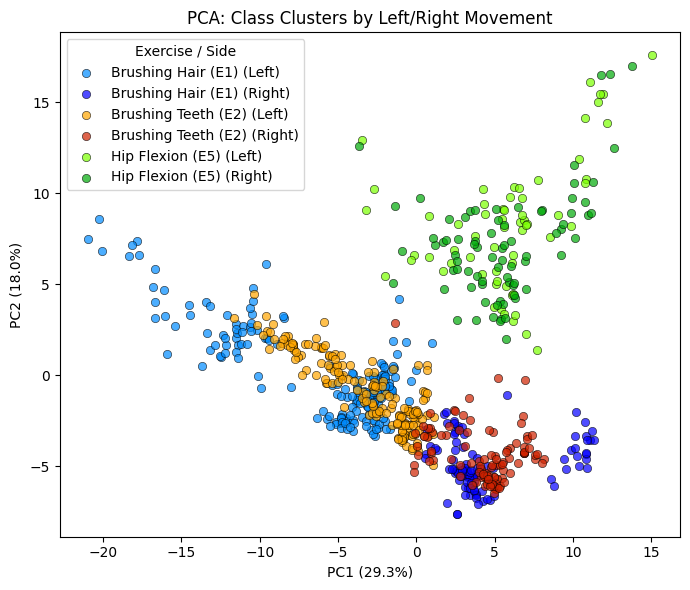

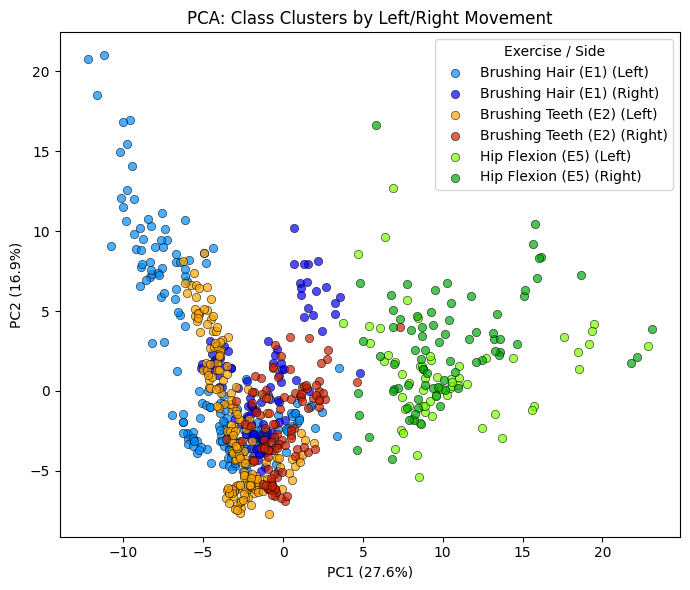

In [ ]:
# PCA plot: each class subdivided by left/right movement, similar colors for left/right subclasses
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Compute left/right label for each sample
y_lr = np.array([detect_mov_side(x) for x in X_norm])  # 'left' or 'right'

# Assign a numeric code for left/right per class: 0=class0_left, 1=class0_right, 2=class1_left, ...
y_cls_lr = np.array([int(y[i]) * 2 + (0 if y_lr[i]=='left' else 1) for i in range(len(y))])

# Color palette: similar colors for left/right of each class
base_colors = ['tab:blue', 'tab:orange', 'tab:green']
light_colors = ["#008cff", "#ffa600", "#7bff00"]  # lighter for left
dark_colors = ["#0400ff", "#cf2200", "#00aa09"]   # darker for right
color_map = [light_colors[0], dark_colors[0], light_colors[1], dark_colors[1], light_colors[2], dark_colors[2]]
labels = [
    f"{CLASS_NAME[0]} (Left)", f"{CLASS_NAME[0]} (Right)",
    f"{CLASS_NAME[1]} (Left)", f"{CLASS_NAME[1]} (Right)",
    f"{CLASS_NAME[2]} (Left)", f"{CLASS_NAME[2]} (Right)"
]

# PCA
for X in [X_std, X_mirror_std]:
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    evr = pca.explained_variance_ratio_ * 100

    plt.figure(figsize=(7, 6))
    for idx in range(6):
        pts = X_pca[y_cls_lr == idx]
        plt.scatter(pts[:, 0], pts[:, 1], alpha=0.7, label=labels[idx], color=color_map[idx], edgecolor='k', linewidth=0.5)

    plt.xlabel(f"PC1 ({evr[0]:.1f}%)")
    plt.ylabel(f"PC2 ({evr[1]:.1f}%)")
    plt.title("PCA: Class Clusters by Left/Right Movement")
    plt.legend(title="Exercise / Side", fontsize=10)
    plt.tight_layout()
    plt.show()

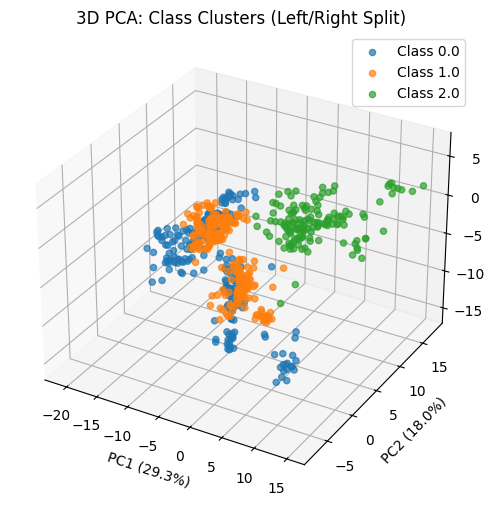

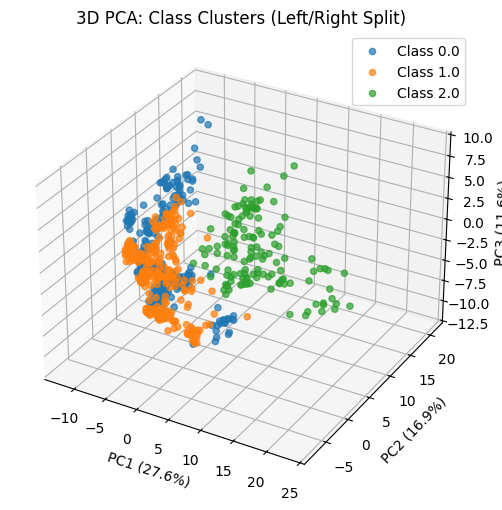

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

for X in [X_std, X_mirror_std]:
    pca3 = PCA(n_components=3)
    X_pca3 = pca3.fit_transform(X)

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')

    for cls in np.unique(y):
        pts = X_pca3[y == cls]
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], alpha=0.7, label=f"Class {cls}")

    ax.set_xlabel(f"PC1 ({pca3.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca3.explained_variance_ratio_[1]*100:.1f}%)")
    ax.set_zlabel(f"PC3 ({pca3.explained_variance_ratio_[2]*100:.1f}%)")
    ax.legend()
    plt.title("3D PCA: Class Clusters (Left/Right Split)")
    plt.show()

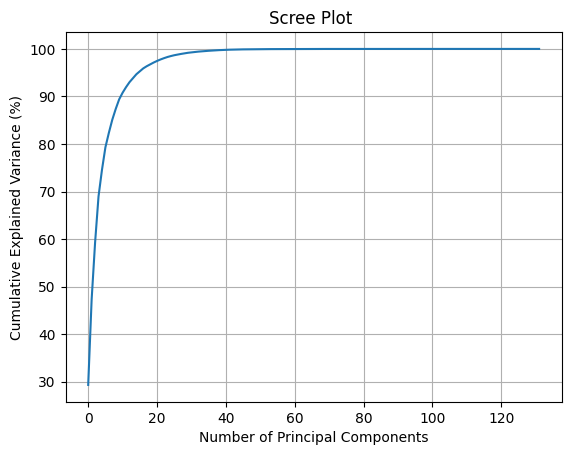

10 PCA components explain  89.39794511063972


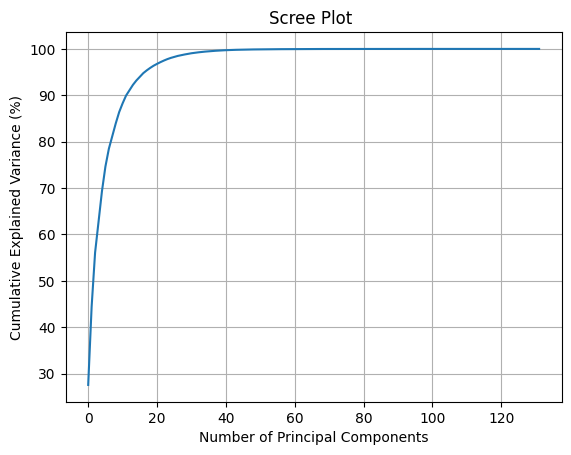

10 PCA components explain  86.38400898256364


In [ ]:
import matplotlib.pyplot as plt

for X in [X_std, X_mirror_std]:
    pca = PCA().fit(X)
    plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance (%)")
    plt.title("Scree Plot ")
    plt.grid(True)
    plt.show()

    print("10 PCA components explain ", np.sum(pca.explained_variance_ratio_[:10]) * 100)

In [ ]:
from sklearn.metrics import silhouette_score

score_before = silhouette_score(X_std, y)
score_after = silhouette_score(X_mirror_std, y)
print(f"Silhouette before: {score_before:.3f}, after: {score_after:.3f}")

Silhouette before: 0.078, after: 0.074


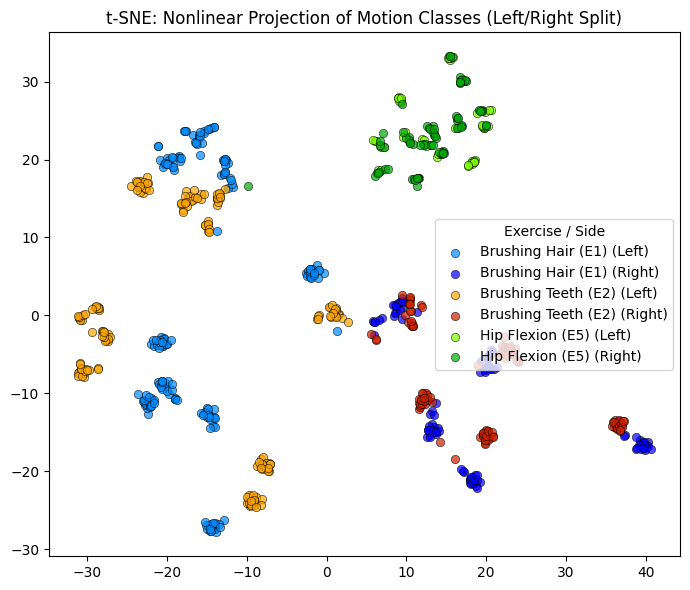

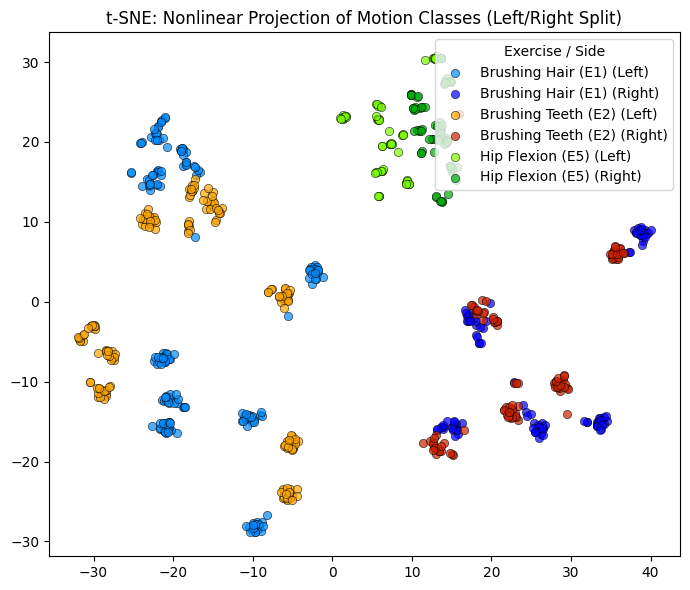

In [ ]:
from sklearn.manifold import TSNE

y_cls_lr = np.array([int(y[i]) * 2 + (0 if y_lr[i]=='left' else 1) for i in range(len(y))])

# Color palette: similar colors for left/right of each class
light_colors = ["#008cff", "#ffa600", "#7bff00"]  # left
dark_colors = ["#0400ff", "#cf2200", "#00aa09"]   # right
color_map = [light_colors[0], dark_colors[0], light_colors[1], dark_colors[1], light_colors[2], dark_colors[2]]
labels = [
    f"{CLASS_NAME[0]} (Left)", f"{CLASS_NAME[0]} (Right)",
    f"{CLASS_NAME[1]} (Left)", f"{CLASS_NAME[1]} (Right)",
    f"{CLASS_NAME[2]} (Left)", f"{CLASS_NAME[2]} (Right)"
]

for X in [X_std, X_mirror_std]:
    X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X)
    plt.figure(figsize=(7, 6))
    for idx in range(6):
        pts = X_tsne[y_cls_lr == idx]
        plt.scatter(pts[:,0], pts[:,1], color=color_map[idx], alpha=0.7, label=labels[idx], edgecolor='k', linewidth=0.5)
    plt.title("t-SNE: Nonlinear Projection of Motion Classes (Left/Right Split)")
    plt.legend(title="Exercise / Side", fontsize=10)
    plt.tight_layout()
    plt.show()

## Visualize Mean and Std of Each Keypoint in XY for a Single Exercise and Patient (with Labels and Body Part Colors)

This cell plots the mean position (x, y) of each keypoint for a single exercise and patient, with error bars representing the standard deviation. Each point is labeled with its keypoint index and colored by body part: head, right arm, left arm, left leg, right leg.

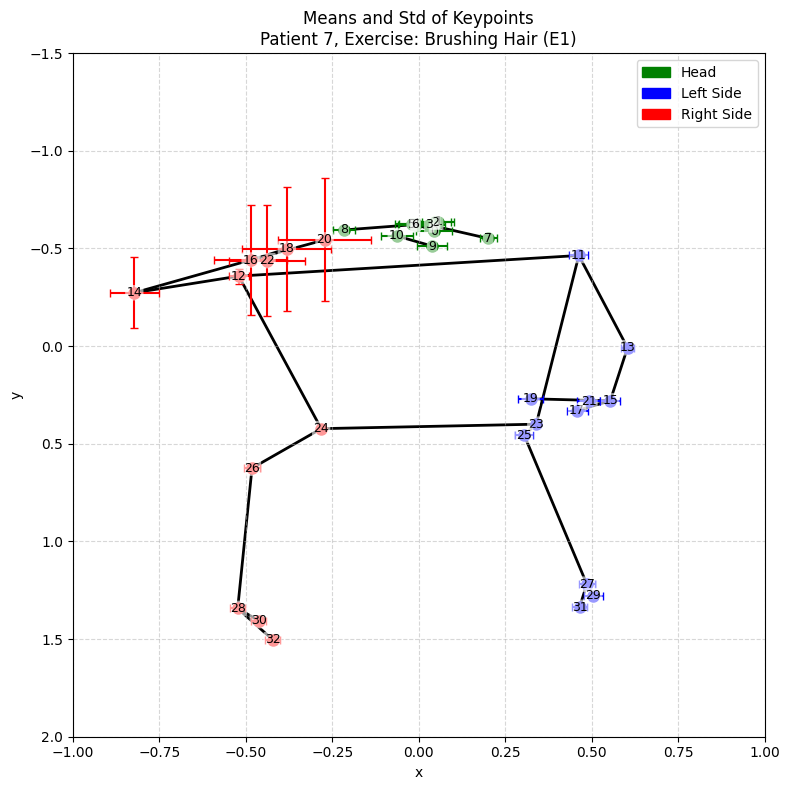

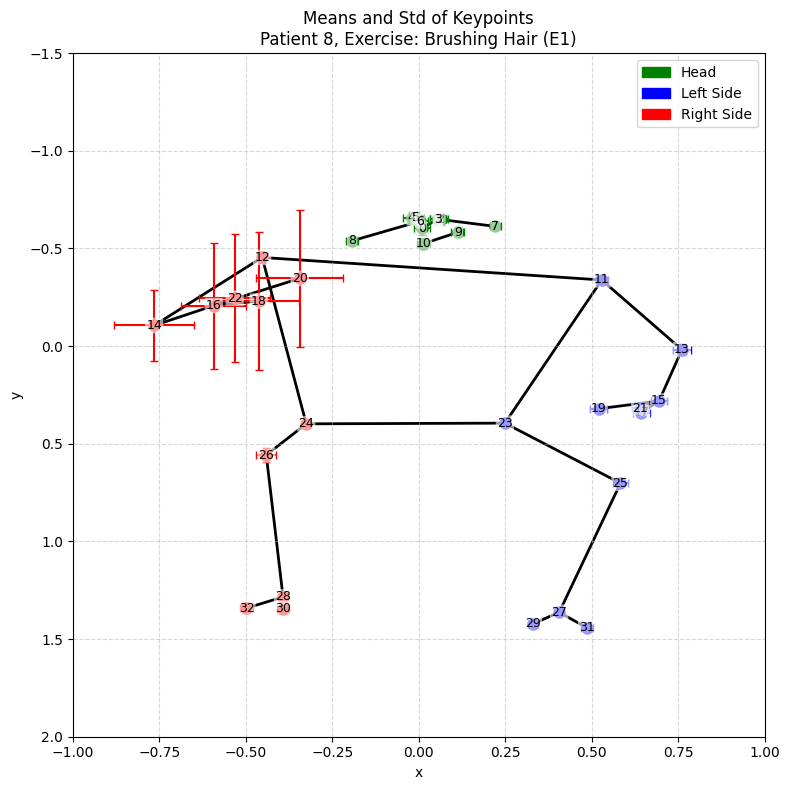

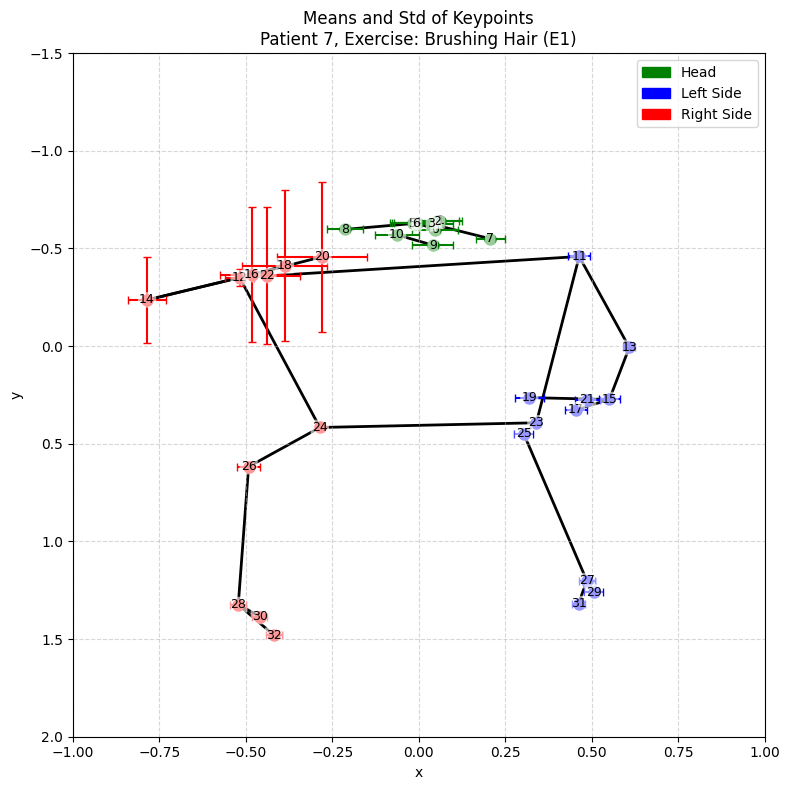

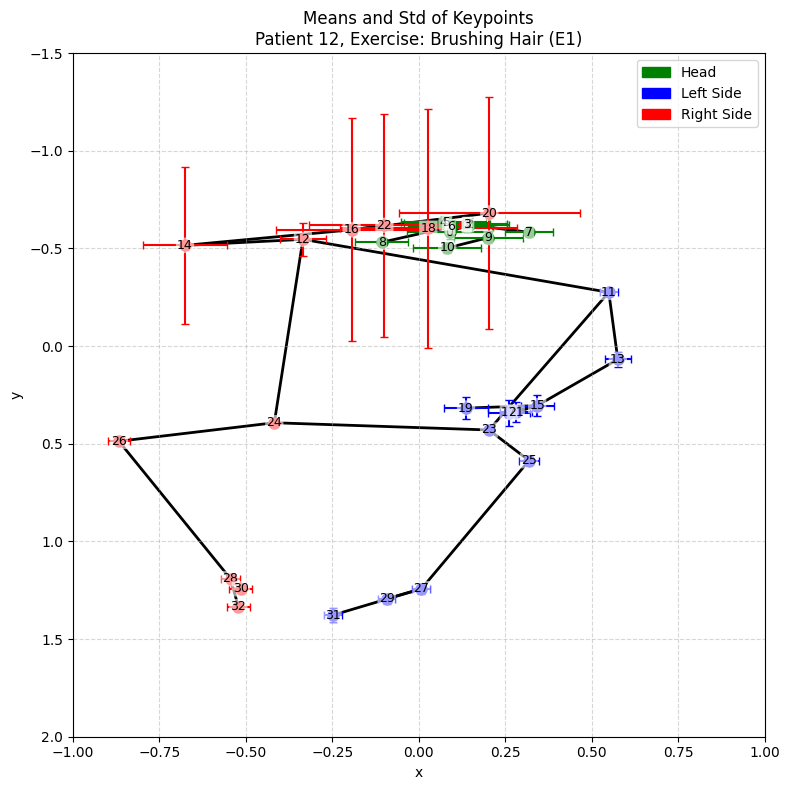

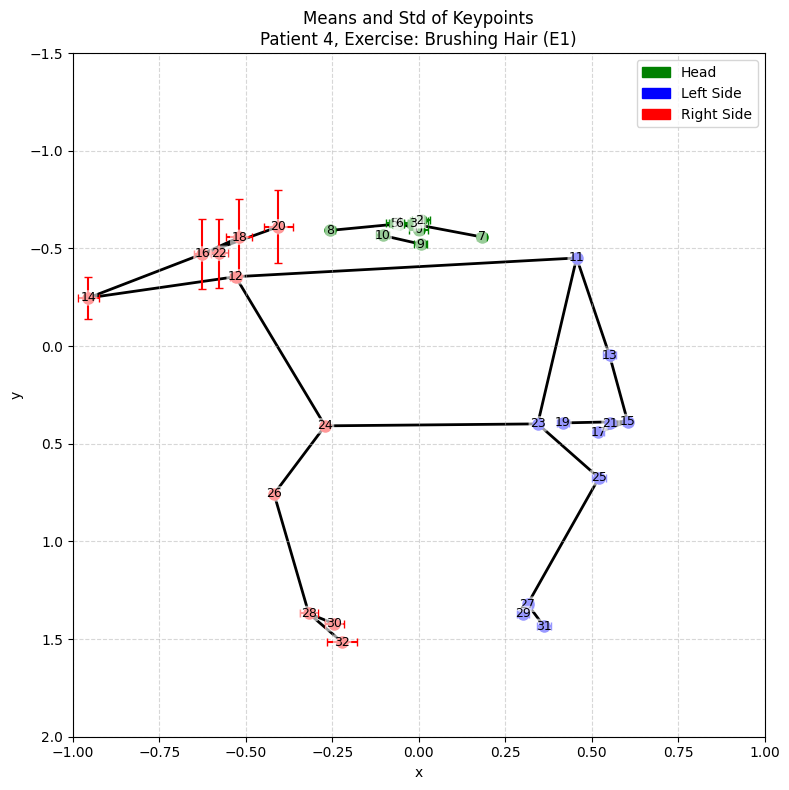

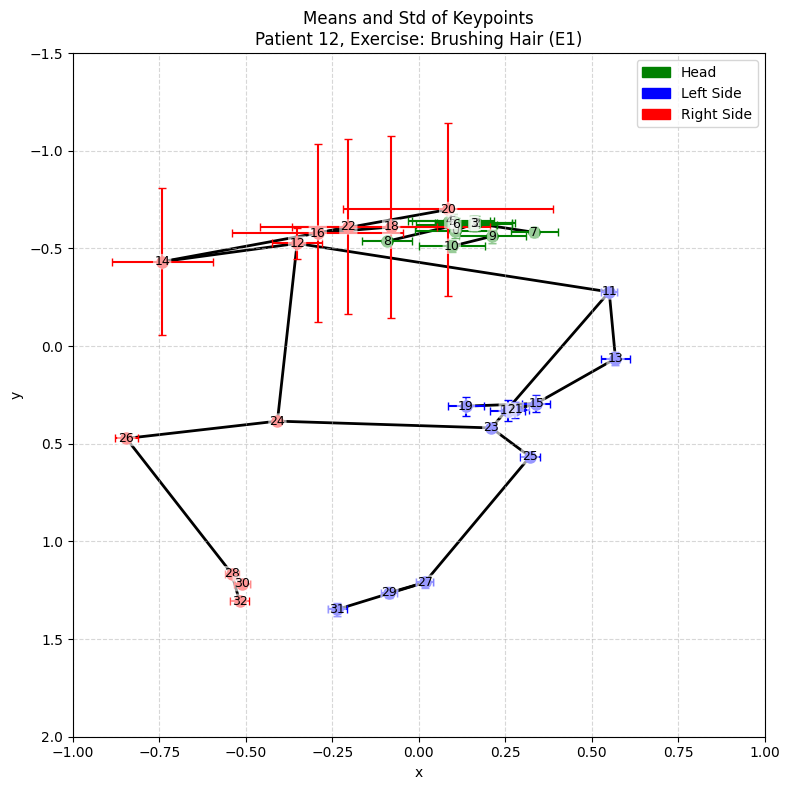

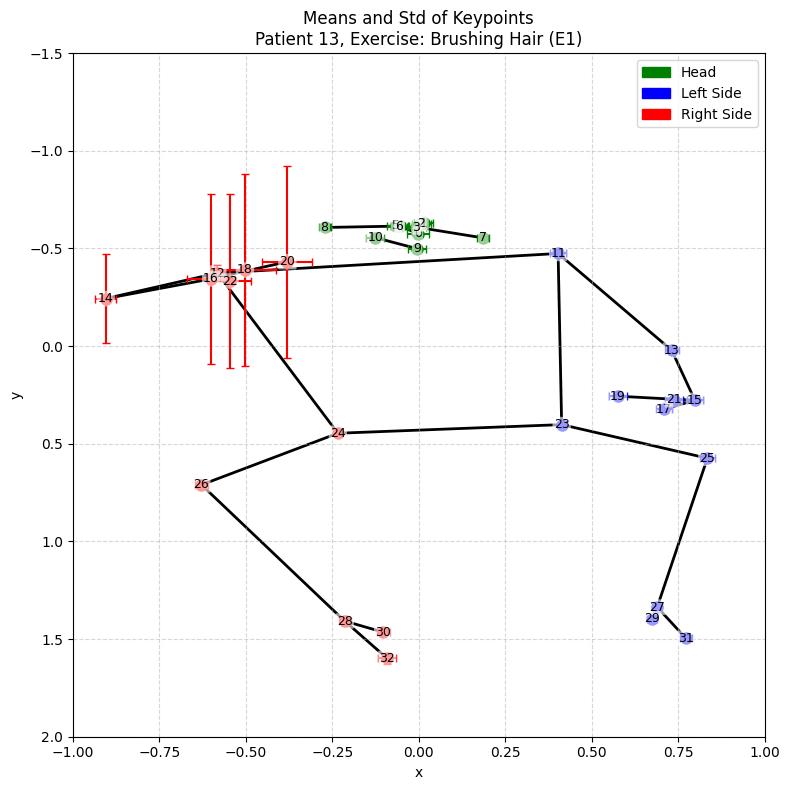

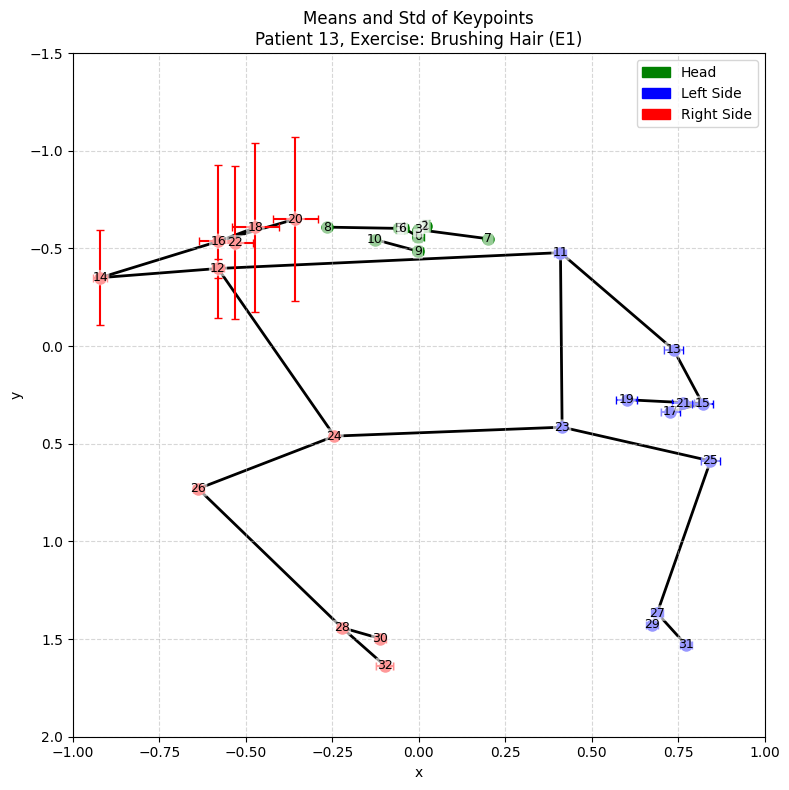

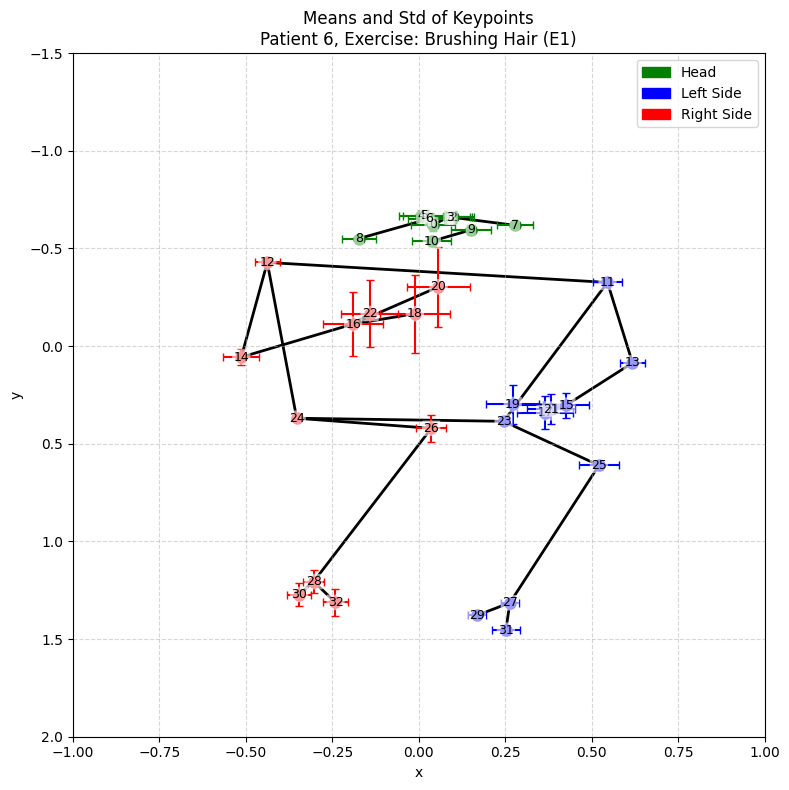

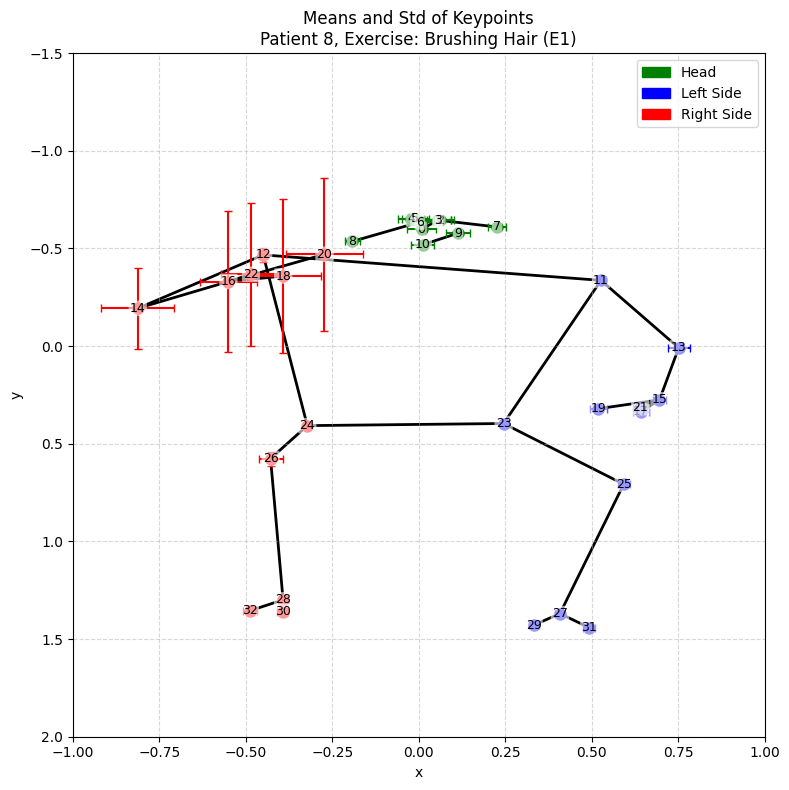

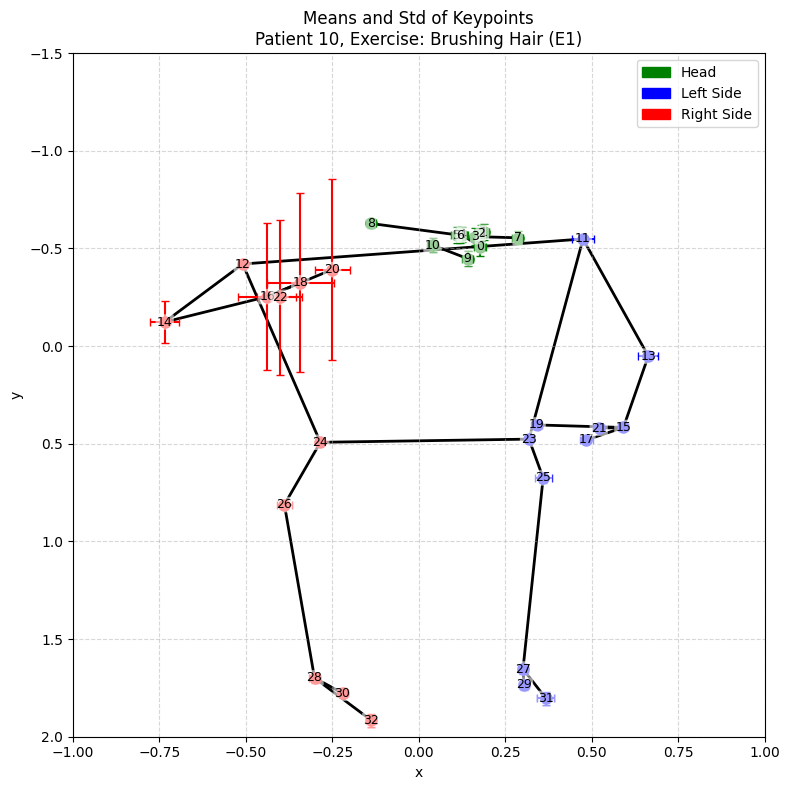

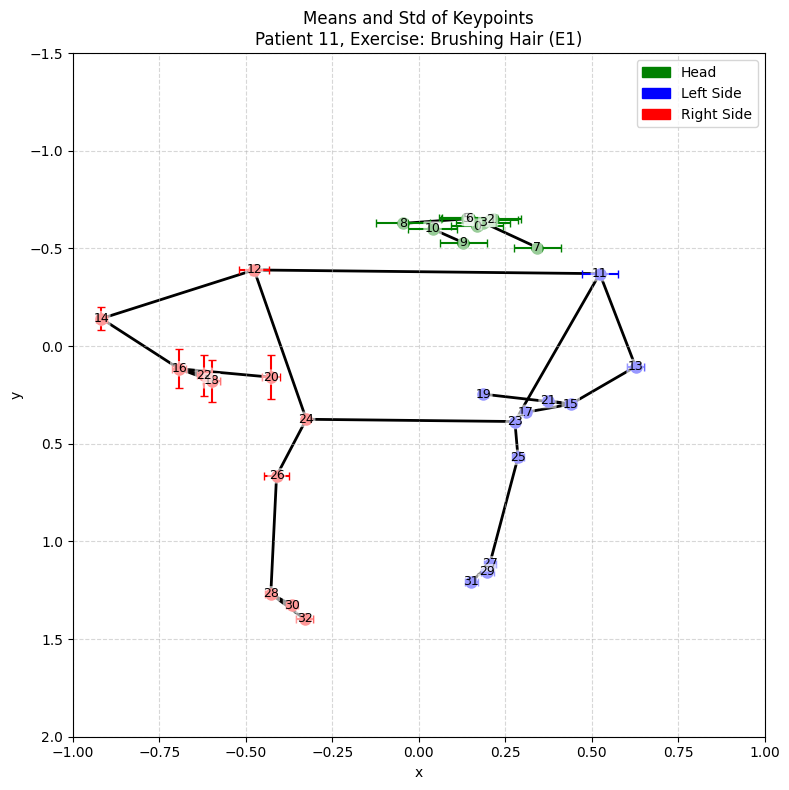

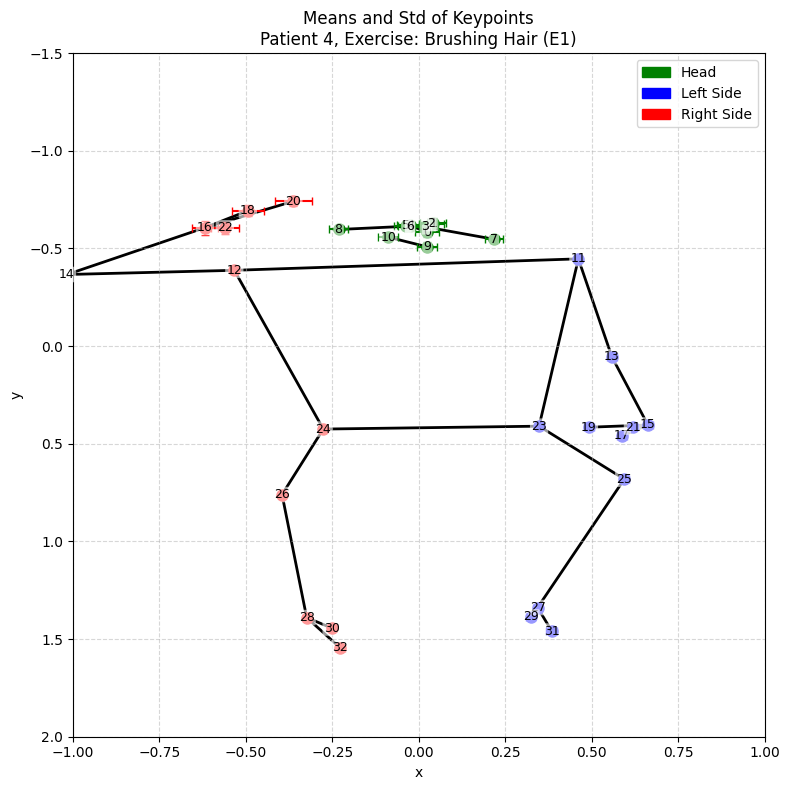

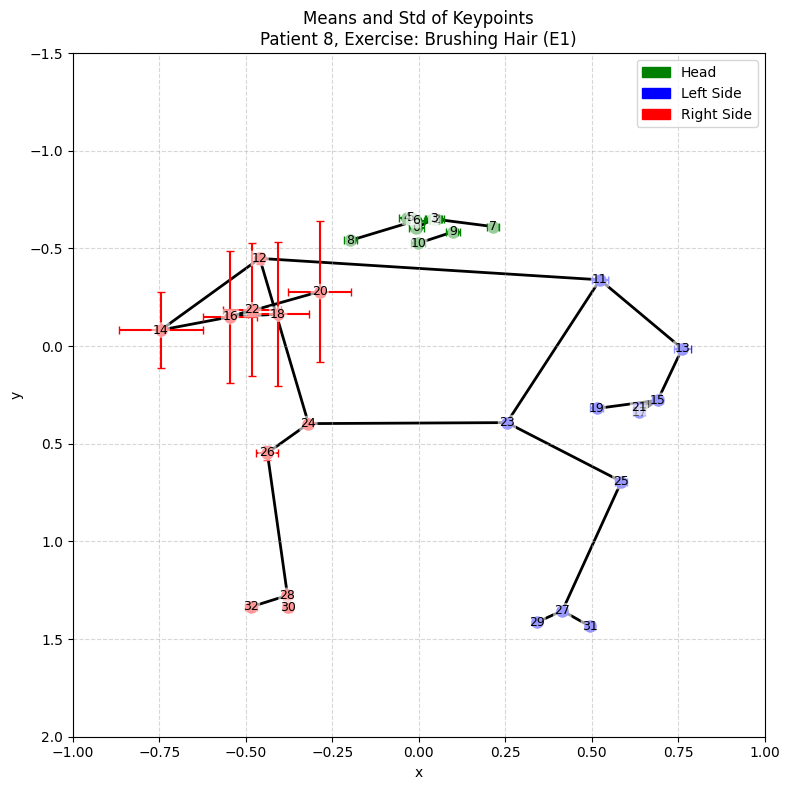

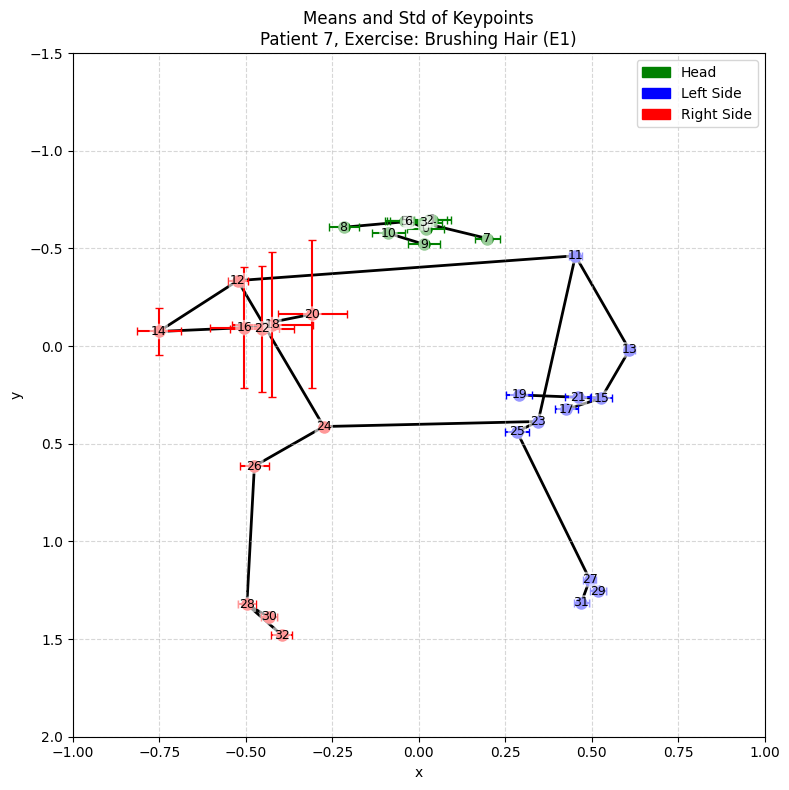

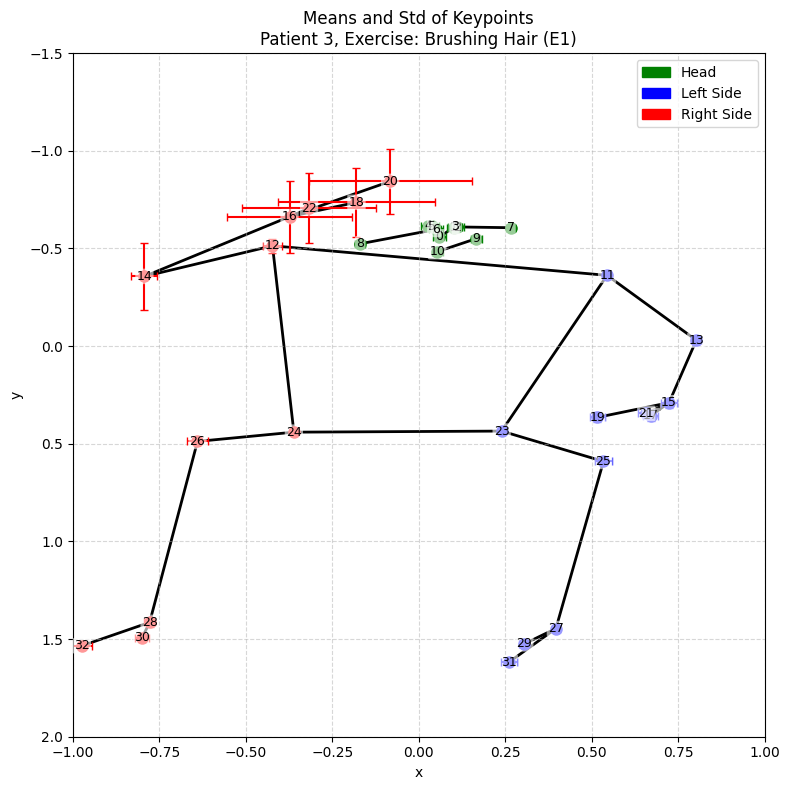

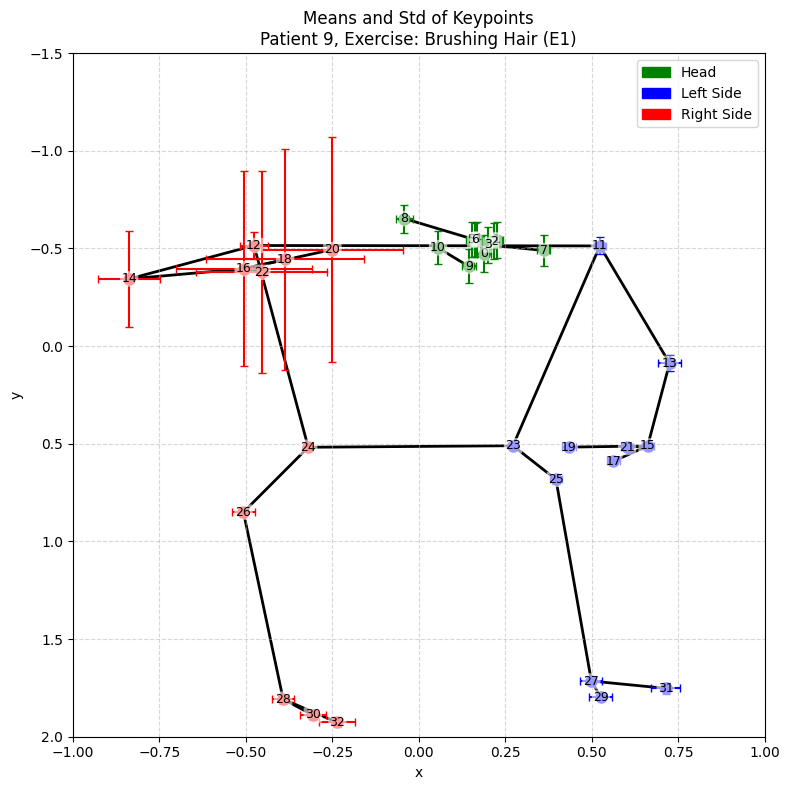

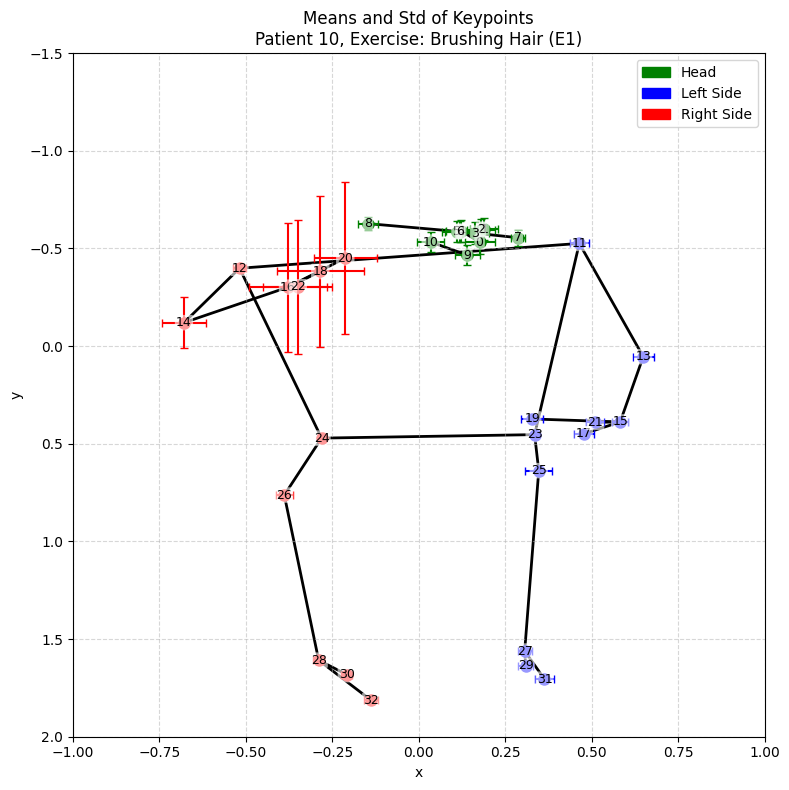

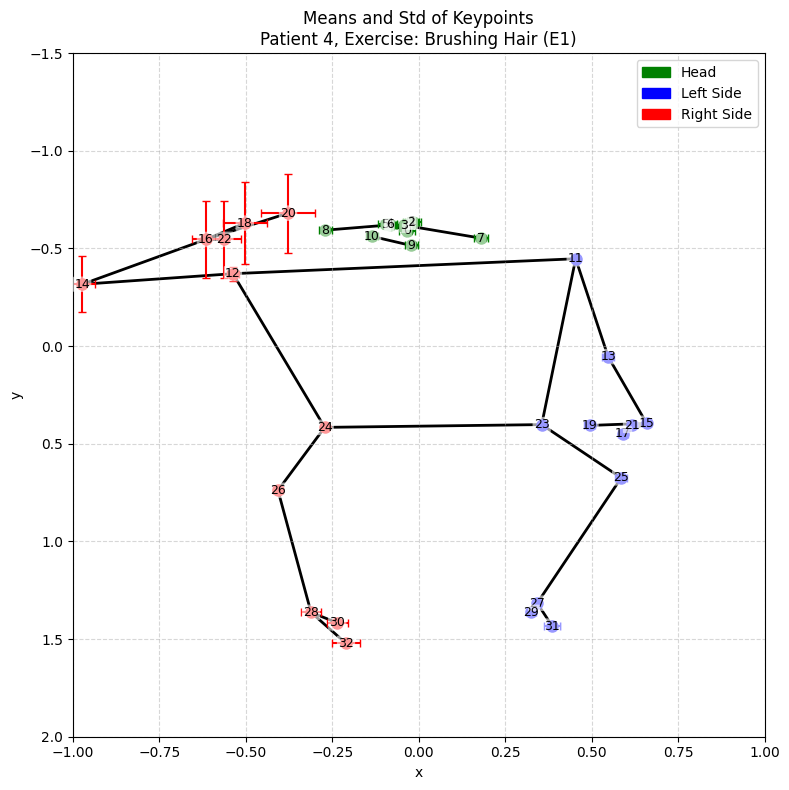

In [ ]:
# Divide body in 4 colored parts
bodypart_colors = np.array(
    ['green'] * 11 +  # 0-10: head
    ['blue', 'red', 'blue', 'red', 'blue', 'red'] +  # 11-16: arms
    ['blue', 'red', 'blue', 'red', 'blue', 'red'] +  # 17-22: hands
    ['blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red']  # 23-32: legs
)

#loop
CLASS = 0
INDEX_LIMIT = 50
for row_idx in [i for i in X1.index if y[i] == CLASS and i < INDEX_LIMIT]:
    patient_id = X1.iloc[row_idx]['Patient_Id']
    exercise_label = y[row_idx]
    exercise_name = CLASS_NAME[exercise_label]

    # Extract means and stds for all 33 keypoints (x, y for each)
    features = X_mirror[row_idx]
    means = features[:66].reshape(33, 2)  # shape (33, 2)
    stds = features[66:].reshape(33, 2)   # shape (33, 2)

    plt.figure(figsize=(8, 8))
    for i in range(33):
        plt.errorbar(means[i, 0], means[i, 1], xerr=stds[i, 0], yerr=stds[i, 1], fmt='o',
                    color=bodypart_colors[i], ecolor=bodypart_colors[i], capsize=3, markersize=8)
        plt.text(means[i, 0], means[i, 1], str(i), fontsize=9, ha='center', va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.1'))

    # Custom legend for body parts
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='green', label='Head'),
        mpatches.Patch(color='blue', label='Left Side'),
        mpatches.Patch(color='red', label='Right Side'),
    ]
    plt.legend(handles=legend_patches, loc='upper right')

    # Define skeleton edges (from your skeleton.png)
    skeleton_edges = [
        (0,1),(1,2),(2,3),(3,7),(0,4),(4,5),(5,6),(6,8),(9,10),
        (11,12),(11,23),(12,24),(23,24),
        (11,13),(13,15),(15,17),(15,19),(15,21),
        (12,14),(14,16),(16,18),(16,20),(16,22),
        (23,25),(25,27),(27,29),(27,31),
        (24,26),(26,28),(28,30),(28,32)
    ]
    # Draw skeleton lines in black
    for (i, j) in skeleton_edges:
        plt.plot([means[i,0], means[j,0]], [means[i,1], means[j,1]], 'k-', linewidth=2, zorder=1)

    plt.title(f'Means and Std of Keypoints\nPatient {patient_id}, Exercise: {exercise_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-1, 1])
    plt.ylim([-1.5, 2])
    plt.gca().invert_yaxis()  # Invert y for image coordinates
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

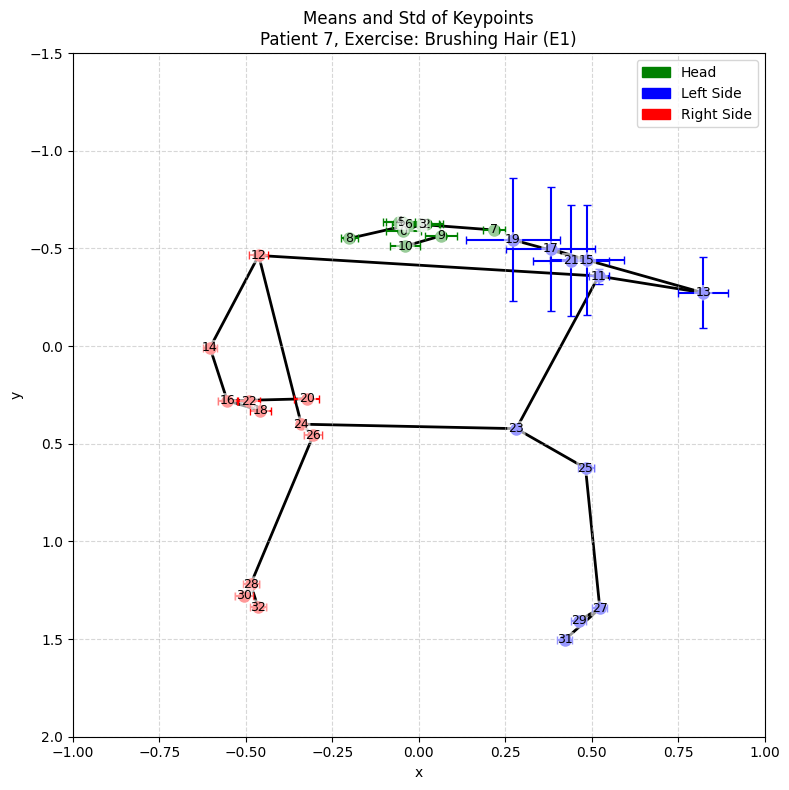

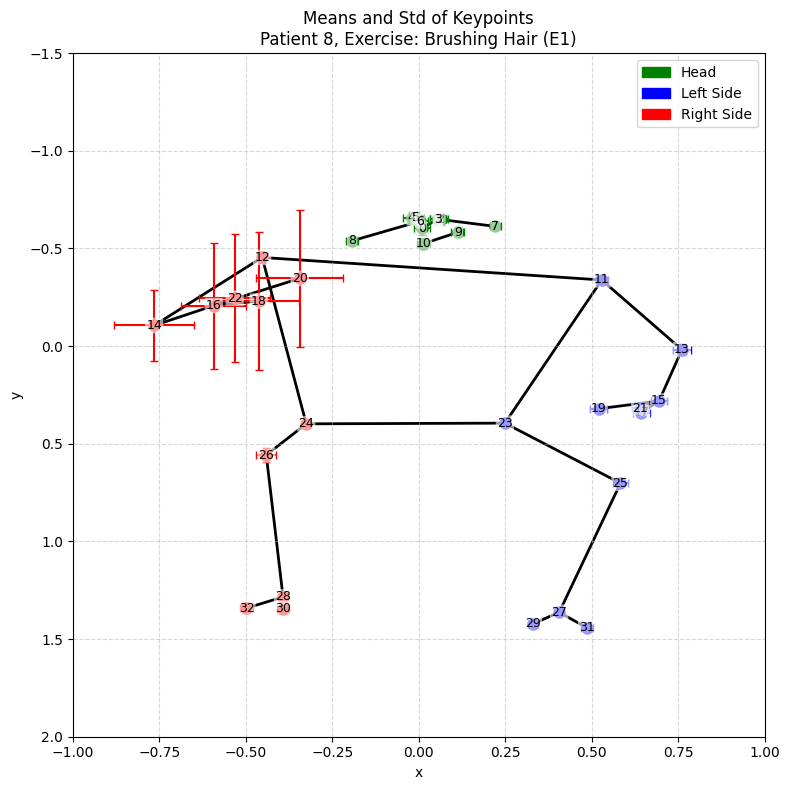

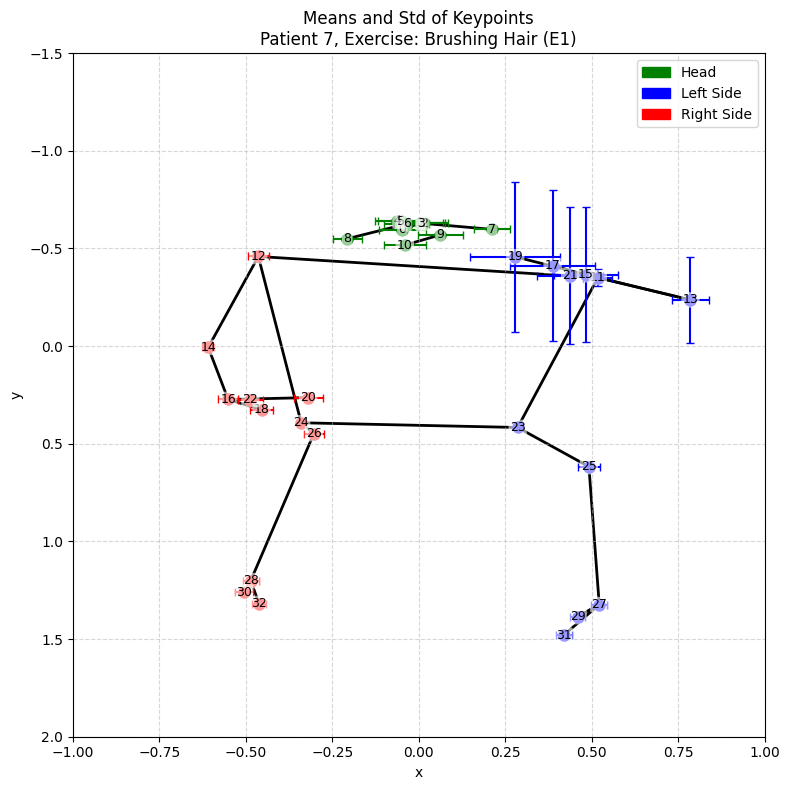

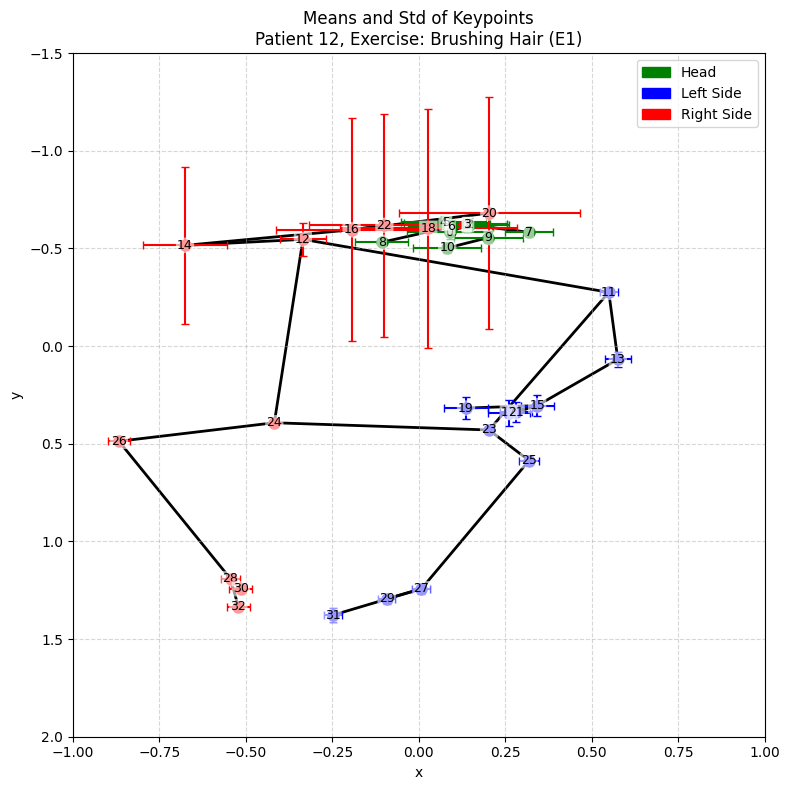

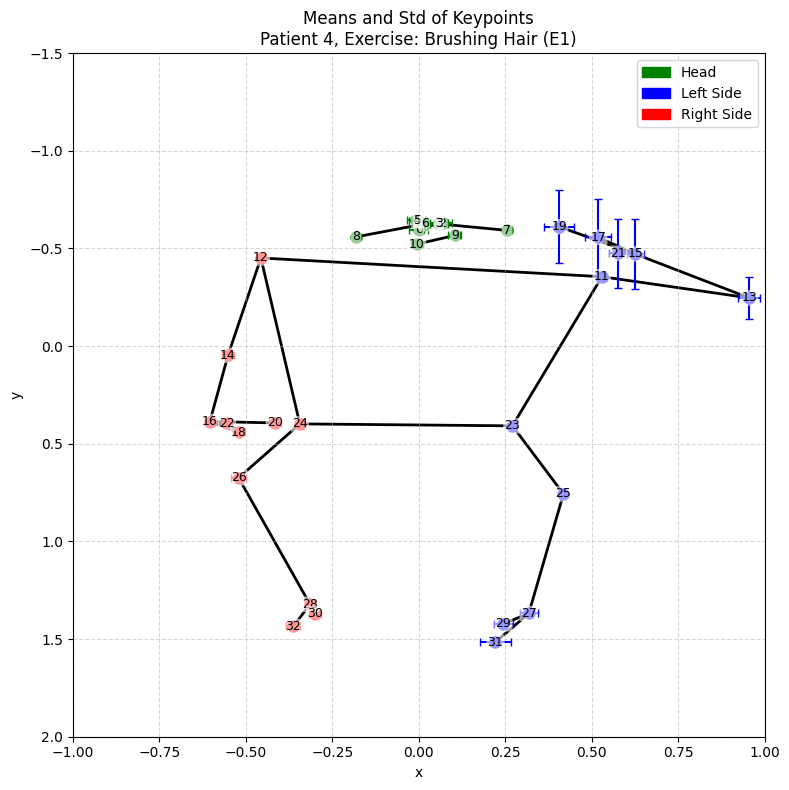

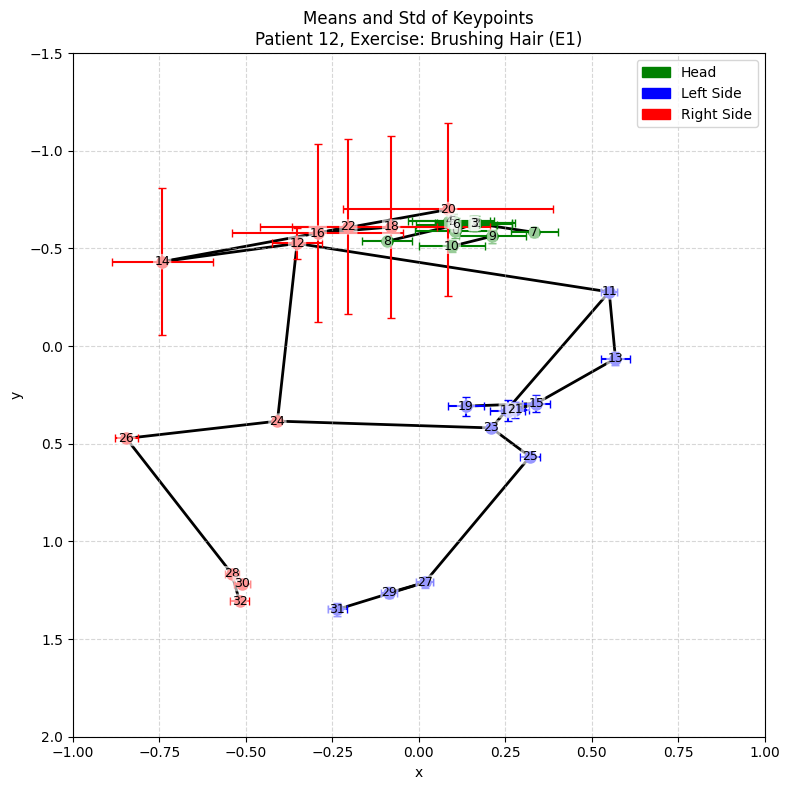

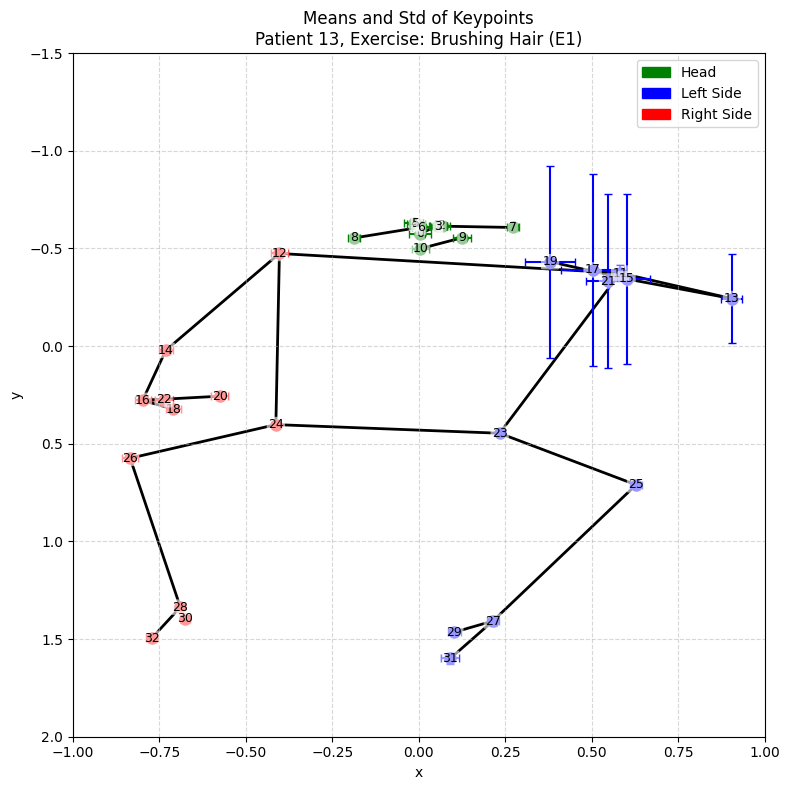

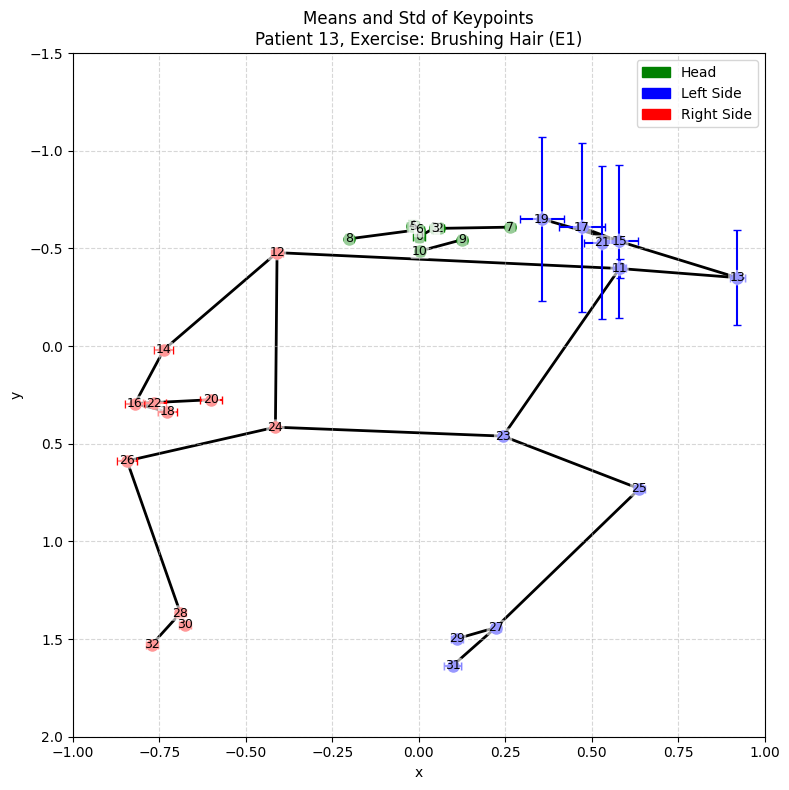

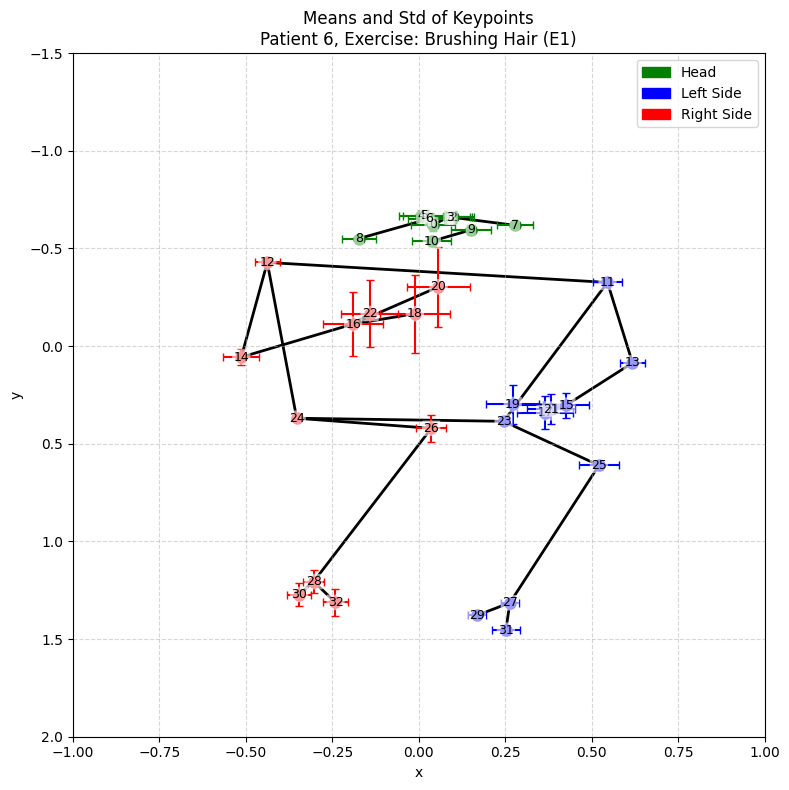

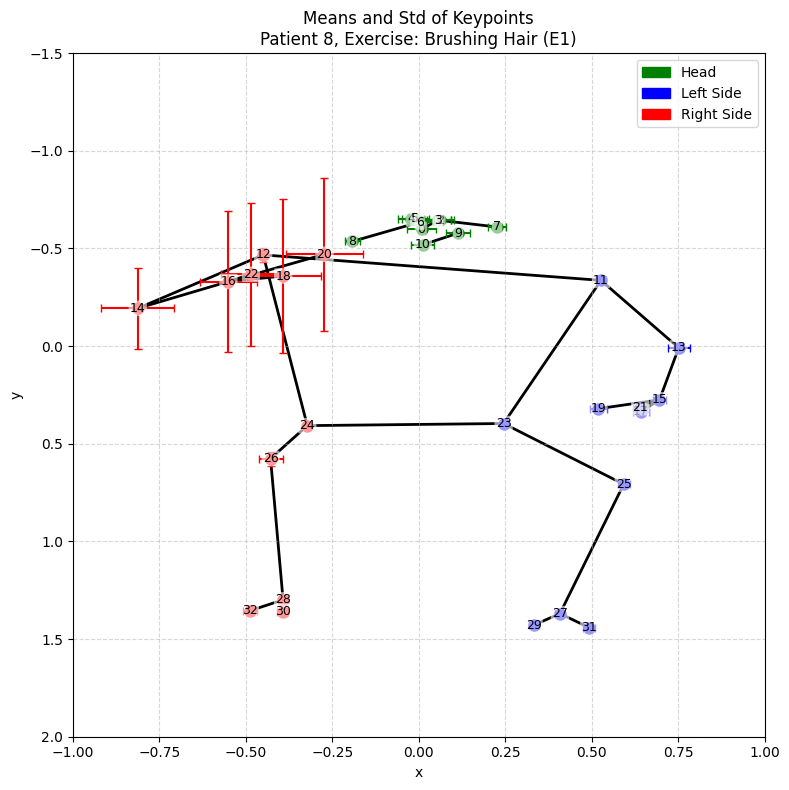

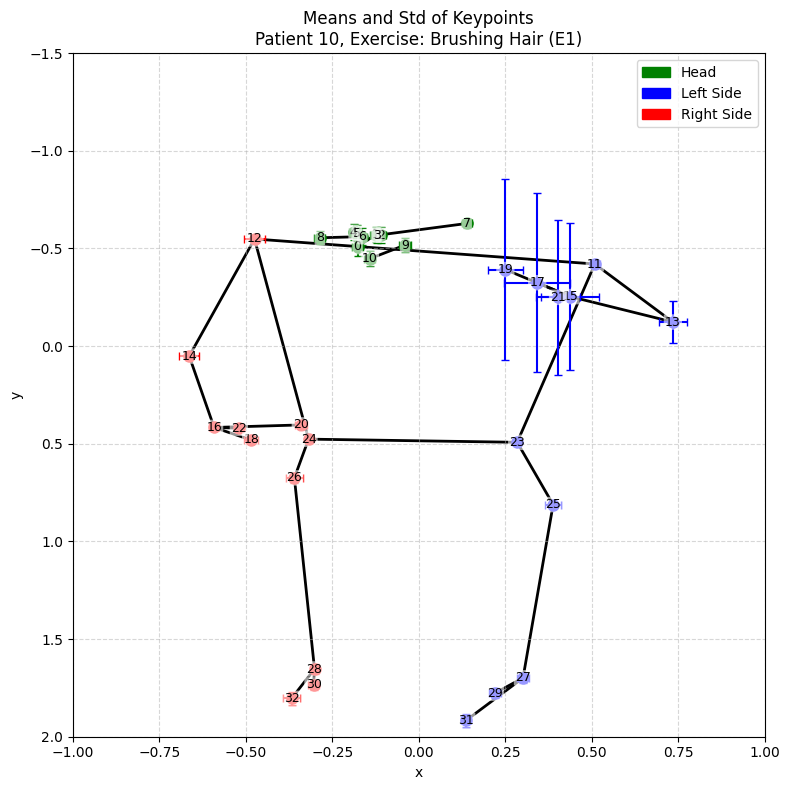

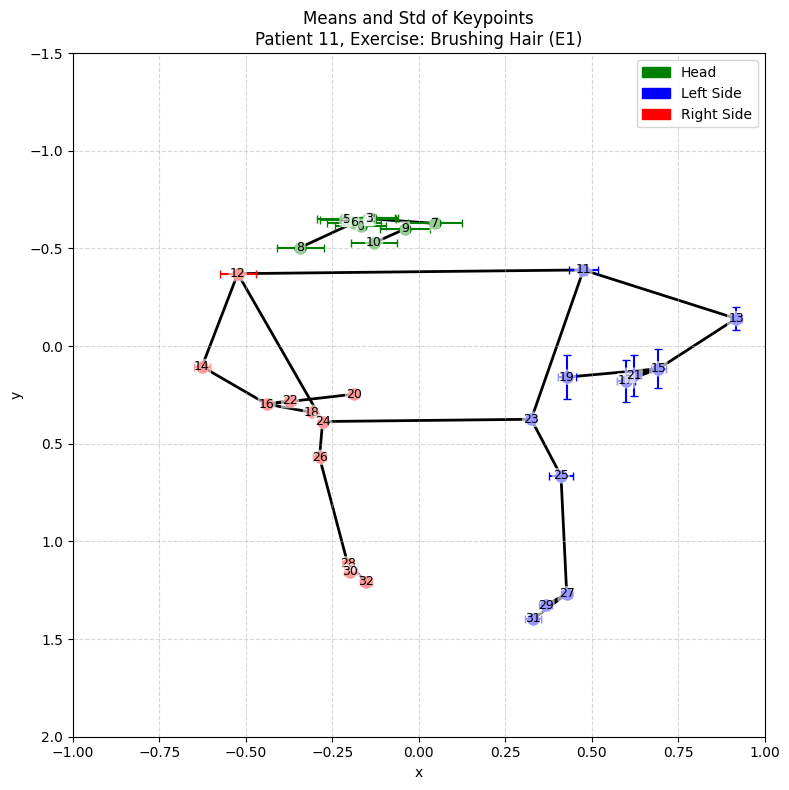

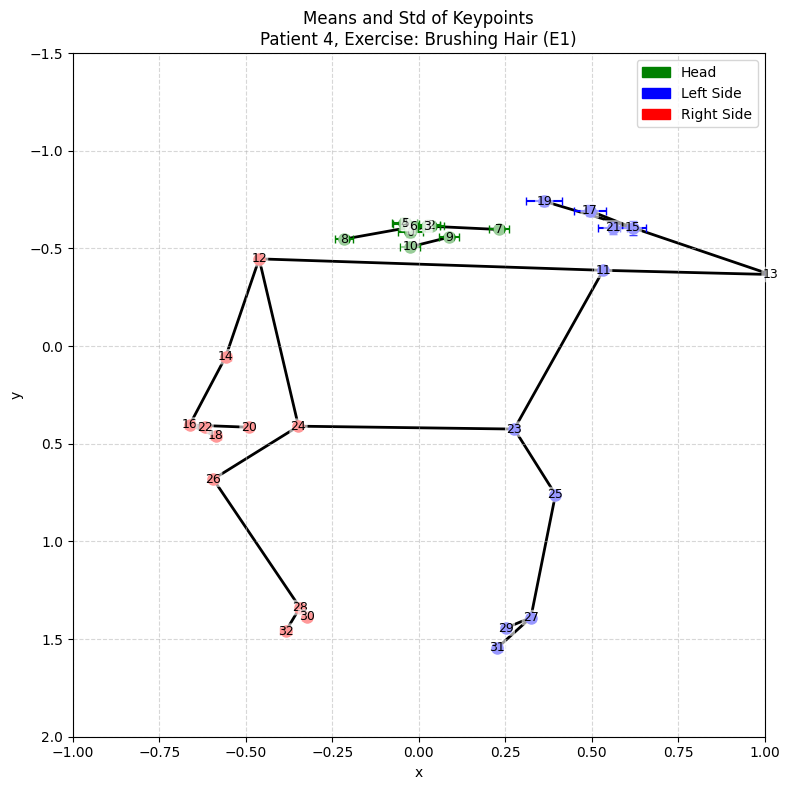

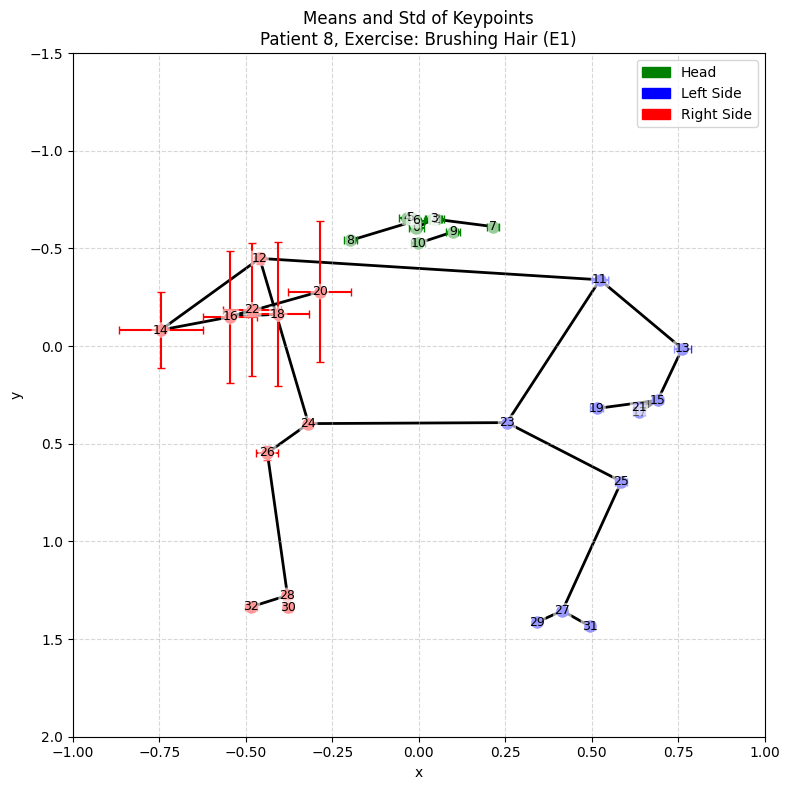

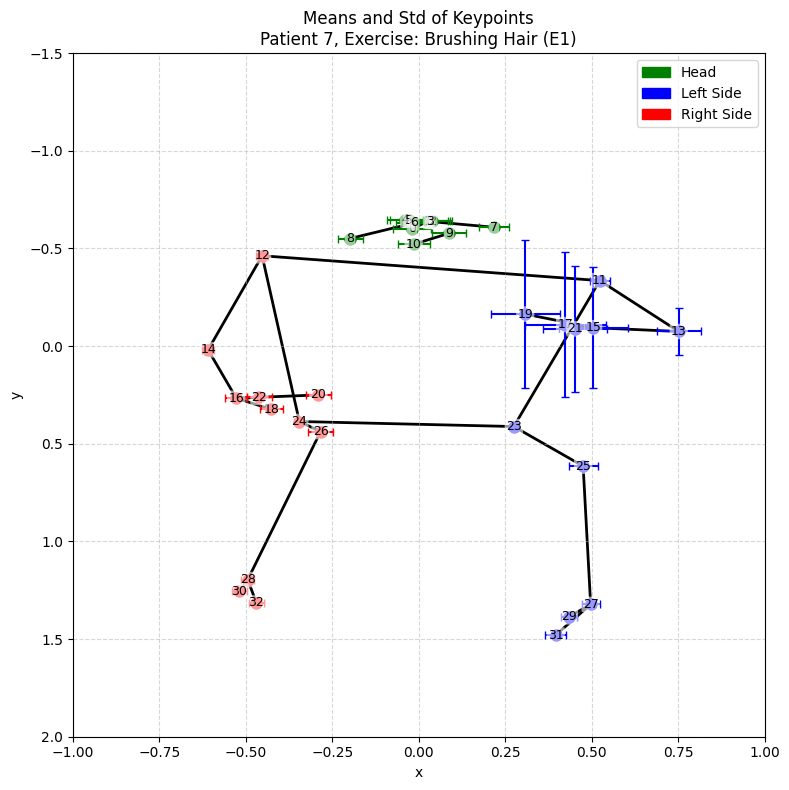

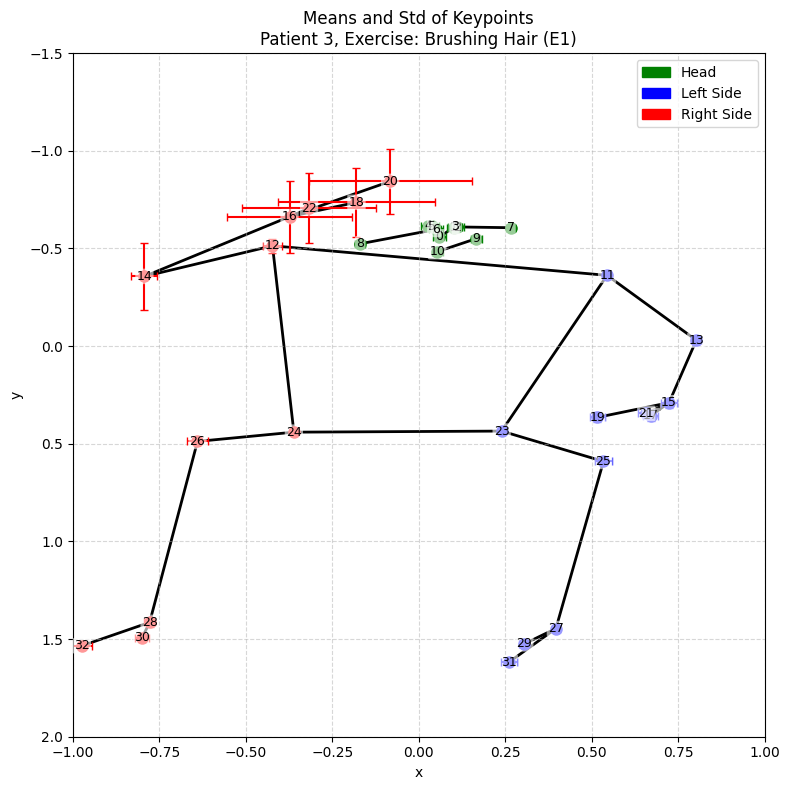

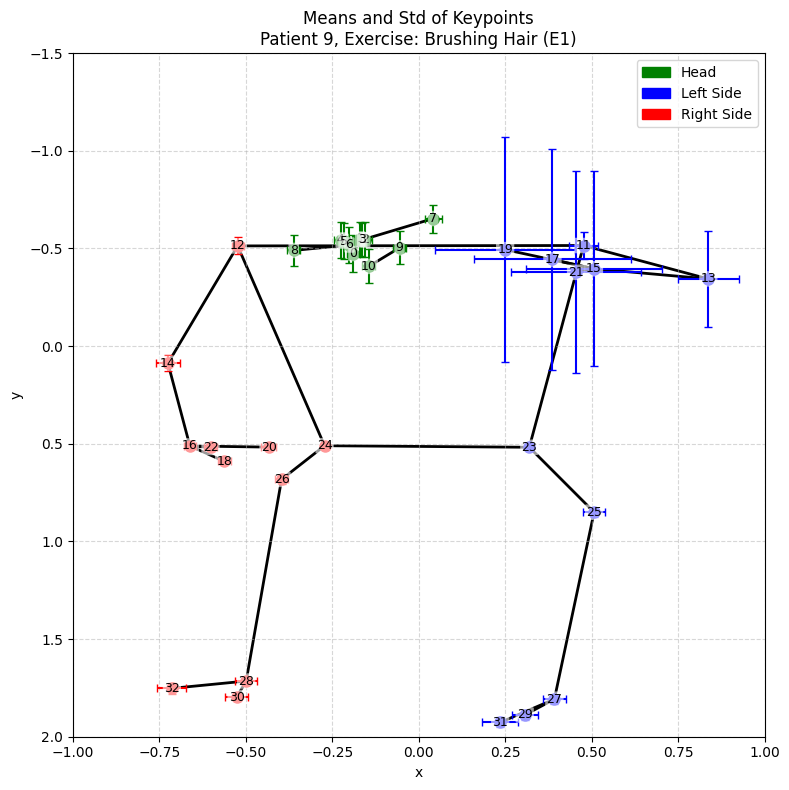

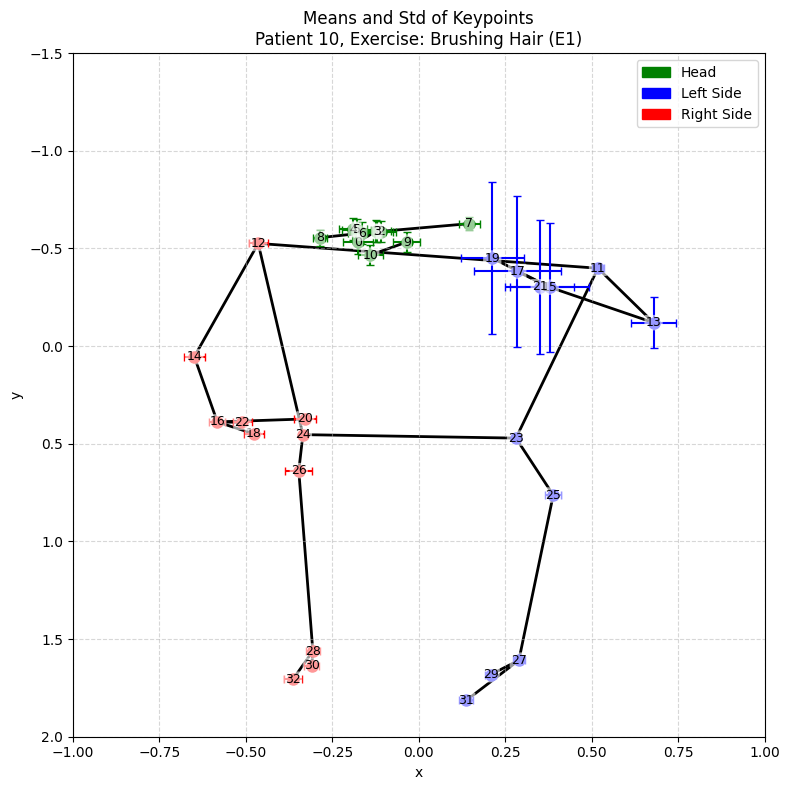

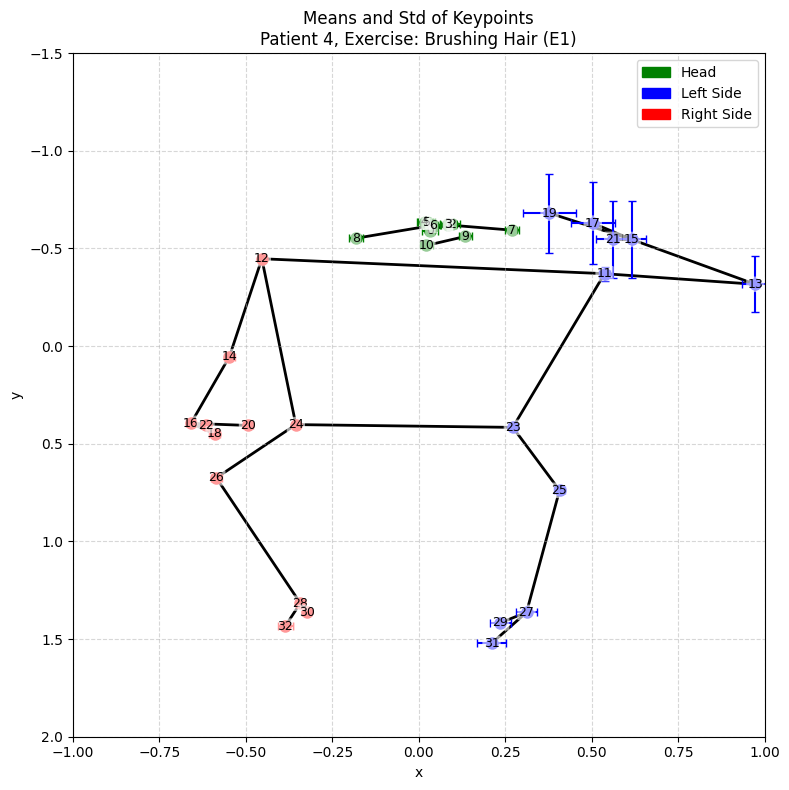

In [44]:
# Divide body in 4 colored parts
bodypart_colors = np.array(
    ['green'] * 11 +  # 0-10: head
    ['blue', 'red', 'blue', 'red', 'blue', 'red'] +  # 11-16: arms
    ['blue', 'red', 'blue', 'red', 'blue', 'red'] +  # 17-22: hands
    ['blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red']  # 23-32: legs
)

#loop
CLASS = 0
INDEX_LIMIT = 50
for row_idx in [i for i in X1.index if y[i] == CLASS and i < INDEX_LIMIT]:
    patient_id = X1.iloc[row_idx]['Patient_Id']
    exercise_label = y[row_idx]
    exercise_name = CLASS_NAME[exercise_label]

    # Extract means and stds for all 33 keypoints (x, y for each)
    features = X_norm[row_idx]
    means = features[:66].reshape(33, 2)  # shape (33, 2)
    stds = features[66:].reshape(33, 2)   # shape (33, 2)

    plt.figure(figsize=(8, 8))
    for i in range(33):
        plt.errorbar(means[i, 0], means[i, 1], xerr=stds[i, 0], yerr=stds[i, 1], fmt='o',
                    color=bodypart_colors[i], ecolor=bodypart_colors[i], capsize=3, markersize=8)
        plt.text(means[i, 0], means[i, 1], str(i), fontsize=9, ha='center', va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.1'))

    # Custom legend for body parts
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='green', label='Head'),
        mpatches.Patch(color='blue', label='Left Side'),
        mpatches.Patch(color='red', label='Right Side'),
    ]
    plt.legend(handles=legend_patches, loc='upper right')

    # Define skeleton edges (from your skeleton.png)
    skeleton_edges = [
        (0,1),(1,2),(2,3),(3,7),(0,4),(4,5),(5,6),(6,8),(9,10),
        (11,12),(11,23),(12,24),(23,24),
        (11,13),(13,15),(15,17),(15,19),(15,21),
        (12,14),(14,16),(16,18),(16,20),(16,22),
        (23,25),(25,27),(27,29),(27,31),
        (24,26),(26,28),(28,30),(28,32)
    ]
    # Draw skeleton lines in black
    for (i, j) in skeleton_edges:
        plt.plot([means[i,0], means[j,0]], [means[i,1], means[j,1]], 'k-', linewidth=2, zorder=1)

    plt.title(f'Means and Std of Keypoints\nPatient {patient_id}, Exercise: {exercise_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-1, 1])
    plt.ylim([-1.5, 2])
    plt.gca().invert_yaxis()  # Invert y for image coordinates
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()